<h1>Analyzing MNIST</h1>
<h2>Introduction</h2>
<p>In this notebook I take a look at the MNIST data set and use TensorFlow to make multiple models and visualizations on how to analyze the dataset. For those not familiar with the dataset, MNIST is a set of 70 000 hand-written digit images. 60 000 of these images will be used to train our model and 10 000 will be used to test our model.</p>

In [96]:
import matplotlib.pyplot as plt # visualization
import tensorflow as tf # model maker
import numpy as np # linear algebra
from sklearn.metrics import confusion_matrix # Determine model accuracy

<h3>Loading the dataset in from tensorflow</h3>
<p>In order to begin any sort of modeling it is good to bring in all of our data first and have it ready for training. We get our dataset from keras which is a higher level version of tensorflow. we then load the data into their respective variables.</p>

In [97]:
mnist = tf.keras.datasets.mnist
(x_train, y_train_unencoded),(x_test, y_test) = mnist.load_data()

<p>We check to make sure the training and test set have the correct number of images</p>

In [98]:
print("Training-set: %s" % len(x_train))
print("Test-set: %s" % len(x_test))

Training-set: 60000
Test-set: 10000


<h3>One-Hot Encoding</h3>
<p>The goal of this section is to transform our our output into vectors that we can train our input images to predict</p>

In [99]:
y_train_unencoded[0:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [100]:
num_classes = 10
y_train = np.zeros((y_train_unencoded.shape[0], num_classes))
y_train[np.arange(len(y_train_unencoded)), y_train_unencoded] = 1

y_train[0:5,:]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

<p>Notice that our y_train data are all vectors with the label in the i'th position where i is the number that the corresponding image is of.

<h3>Data Dimensions</h3>

In [101]:
img_size = 28
flattened_img_size = img_size ** 2
img_shp = (img_size, img_size)

In [102]:
def plot_imgs(imgs, cls_true, cls_pred=None):
    assert len(imgs) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i].reshape(img_shp), cmap='binary')
        
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

In [103]:
y_test[0]

7

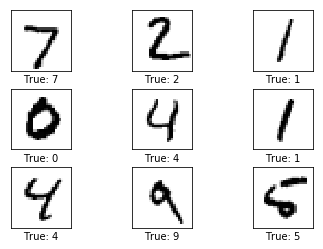

In [104]:
images = x_test[0:9]

cls_true = y_test[0:9]

plot_imgs(imgs=images, cls_true=cls_true)

<h3>Model building</h3>

In [105]:
x = tf.placeholder(tf.float32, [None, flattened_img_size]) 
#input layer takes in flattened 28 by 28 images to train

In [106]:
y_true = tf.placeholder(tf.float32, [None, num_classes]) 
#output layer (vectors that have a 1 in the i'th position based on the prediction)

In [107]:
y_true_cls = tf.placeholder(tf.int64, [None])
#Actual number being predicted [0,9]

In [108]:
weights = tf.Variable(tf.zeros([flattened_img_size, num_classes]))

In [109]:
biases = tf.Variable(tf.zeros([num_classes]))

<p>Before we build the complex convolutional neural network model we prototype a simpler linear model just for the sake of it. This linear function is gonna be built with y_hat = weights * x + biases, which is the linear form everyone is familiar with y = mx + b. The only difference is that we're going to be working in a much larger dimension.</p>

In [110]:
logits = tf.matmul(x, weights) + biases

<p>Logits is the result of the calculation that is made from the linear model and gives a estimate of how likely each image is to be each value.</p>

In [111]:
y_pred = tf.nn.softmax(logits)

<p>The softmax function then normalizes the predictions of each digit</p>

In [112]:
y_pred_cls = tf.argmax(y_pred, axis=1)

<h4>Tuning the weights and biases</h4>

<p>Cross entropy is a cost function for classifiers that measures the models performance. We then take the performance and make it a single scalar and send it forward to the optimizer in order to determine how the network wants to change its weight parameters.</p>

In [113]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

<h3>Optimization</h3>
<p>We use the most basic optimizer in tensorflow to train our weights</p>

In [114]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost) 

<h2>Evaluating performance</h2>
<p>Determines if the prediction is the same as the ground truth value</p>

In [115]:
correct_prediction =tf.equal(y_true_cls, y_pred_cls)

<p>Turns the booelan values of which predictions were right and wrong and makes it into 0 for false and 1 for true to determine the accuracy of our predictions</p>

In [116]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

<h2>Training the model</h2>

In [117]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

In [118]:
batch_size = 100

In [119]:
def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch, _ = mnist.load_data().random_batch(batch_size=batch_size)
        feed_dict_train = {
            x: x_batch,
            y_true: y_true_batch
        }
        sess.run(optimizer, feed_dict=feed_dict_train)

<p>Functions to help show our models perforamnce</p>

In [126]:
x_test.reshape

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [120]:
feed_dict_test = {
    x: x_test,
    y_true: y_test
}

In [121]:
def print_accuracy():
    acc = sess.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on tst-set: %f%" % acc)

In [122]:
def print_confusion_matrix():
    cls_true = y_test_cls
    cls_pred = sess.run(y_test, feed_dict=feed_dict_test)
    conmat = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.conmat.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xtickets(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_clases))
    plt.xlabel('Predicted')
    plt.ylabel("True")
    plt.show()

In [123]:
def plot_example_errors():
    correct, cls_pred = sess.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
    incorrect = (correct == False)
    images = data.x_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.y_test_cls[incorrect]
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [124]:
def plot_weights():
    w = sess.run(weights)

    w_min = np.min(w)
    w_max = np.max(w)

    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):

        if i<10:

            image = w[:, i].reshape(img_shape)

            ax.set_xlabel("Weights: {0}".format(i))

            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [125]:
print_accuracy()

ValueError: Cannot feed value of shape (10000, 28, 28) for Tensor 'Placeholder_9:0', which has shape '(?, 784)'